In [2]:
import pandas as pd
import numpy as np
from tabulate import tabulate

# Load and preprocess dataset
df = pd.read_csv('newdata.csv')
df.columns = df.columns.str.strip().str.replace(':', '').str.replace(' ', '')

keep_cols = ['JobID', 'SubmitTime', 'RunTime', 'UsedMemory', 'ReqTime', 'Status']
df = df[keep_cols]
df = df.replace(-1, np.nan)
df = df[df['SubmitTime'].notna() & df['RunTime'].notna()]
df = df[df['RunTime'] > 0]
df = df[df['SubmitTime'] > 0]
df = df.dropna()
df = df.astype({'SubmitTime': float, 'RunTime': float, 'UsedMemory': float, 'ReqTime': float, 'Status': int})

SCALE = 1e6
df['SubmitTime'] = df['SubmitTime'] / SCALE
df['RunTime'] = df['RunTime'] / SCALE
df['ReqTime'] = df['ReqTime'] / SCALE

batch_size = 50
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)
batches = [df_shuffled.iloc[i:i+batch_size] for i in range(0, len(df_shuffled), batch_size)]
print(f"Total random batches created: {len(batches)}")


Total random batches created: 116


In [3]:
def simulate_fcfs(batch, return_metrics=False):
    batch = batch.sort_values('SubmitTime')
    current_time = batch['SubmitTime'].min()
    turnaround_times = []
    busy_time = 0

    for _, row in batch.iterrows():
        start = max(current_time, row['SubmitTime'])
        finish = start + row['RunTime']
        turnaround = finish - row['SubmitTime']
        turnaround_times.append(turnaround)
        busy_time += row['RunTime']
        current_time = finish

    total_time = max(current_time, batch['SubmitTime'].max() + batch['RunTime'].max())
    cpu_util = busy_time / total_time
    avg_tat = np.mean(turnaround_times)
    avg_wait = avg_tat - batch['RunTime'].mean()
    throughput = len(batch) / total_time

    if return_metrics:
        return avg_tat, avg_wait, throughput, cpu_util

    score = (cpu_util * 0.4) + ((1 / (avg_wait + 1e-5)) * 0.3) + ((1 / (avg_tat + 1e-5)) * 0.2) + (throughput * 0.1)
    return score


def simulate_mlfq(batch, num_queues=3, time_quantums=[5, 10], return_metrics=False):
    jobs = batch.copy()
    jobs['Remaining'] = jobs['RunTime']
    jobs['Queue'] = 0
    jobs['Scheduled'] = False
    current_time = jobs['SubmitTime'].min()
    turnaround_times = []
    busy_time = 0

    while not jobs['Scheduled'].all():
        available = jobs[(jobs['SubmitTime'] <= current_time) & (~jobs['Scheduled'])]

        if available.empty:
            current_time = jobs[~jobs['Scheduled']]['SubmitTime'].min()
            continue

        scheduled_in_this_cycle = False

        for q in range(num_queues):
            candidates = available[available['Queue'] == q]
            if candidates.empty:
                continue

            if q < num_queues - 1:
                # Round Robin for upper queues
                for idx in candidates.index:
                    job = jobs.loc[idx]
                    tq = time_quantums[q]
                    run_time = min(job['Remaining'], tq)
                    jobs.at[idx, 'Remaining'] -= run_time
                    busy_time += run_time
                    current_time += run_time

                    if jobs.at[idx, 'Remaining'] <= 0:
                        turnaround = current_time - job['SubmitTime']
                        turnaround_times.append(turnaround)
                        jobs.at[idx, 'Scheduled'] = True
                    else:
                        if jobs.at[idx, 'Queue'] < num_queues - 1:
                            jobs.at[idx, 'Queue'] += 1
                scheduled_in_this_cycle = True
                break
            else:
                # FCFS for last queue
                for idx in candidates.sort_values('SubmitTime').index:
                    job = jobs.loc[idx]
                    start = max(current_time, job['SubmitTime'])
                    finish = start + job['Remaining']
                    turnaround = finish - job['SubmitTime']
                    turnaround_times.append(turnaround)
                    busy_time += job['Remaining']
                    current_time = finish
                    jobs.at[idx, 'Remaining'] = 0
                    jobs.at[idx, 'Scheduled'] = True
                scheduled_in_this_cycle = True
                break

        if not scheduled_in_this_cycle:
            current_time += 1  # advance time if nothing scheduled

    total_time = max(current_time, jobs['SubmitTime'].max() + jobs['RunTime'].max())
    cpu_util = busy_time / total_time
    avg_tat = np.mean(turnaround_times)
    avg_wait = avg_tat - batch['RunTime'].mean()
    throughput = len(batch) / total_time

    if return_metrics:
        return avg_tat, avg_wait, throughput, cpu_util

    score = (cpu_util * 0.4) + ((1 / (avg_wait + 1e-5)) * 0.3) + ((1 / (avg_tat + 1e-5)) * 0.2) + (throughput * 0.1)
    return score


def simulate_rr(batch, quantum=10, return_metrics=False):
    jobs = batch.copy()
    jobs['Remaining'] = jobs['RunTime']
    jobs['Scheduled'] = False
    current_time = jobs['SubmitTime'].min()
    turnaround_times = []
    busy_time = 0
    queue = []
    arrived = jobs[jobs['SubmitTime'] <= current_time]
    queue.extend(arrived.index.tolist())

    while not jobs['Scheduled'].all():
        if not queue:
            current_time = jobs[~jobs['Scheduled']]['SubmitTime'].min()
            arrived = jobs[(jobs['SubmitTime'] <= current_time) & (~jobs['Scheduled'])]
            queue.extend(arrived.index.tolist())
            continue

        idx = queue.pop(0)
        job = jobs.loc[idx]
        if job['Scheduled']:
            continue

        run_time = min(job['Remaining'], quantum)
        jobs.at[idx, 'Remaining'] -= run_time
        busy_time += run_time
        current_time = max(current_time, job['SubmitTime']) + run_time

        newly_arrived = jobs[
            (jobs['SubmitTime'] > current_time - run_time) &
            (jobs['SubmitTime'] <= current_time) &
            (~jobs['Scheduled'])
        ]
        queue.extend(newly_arrived.index.tolist())

        if jobs.at[idx, 'Remaining'] <= 0:
            turnaround = current_time - job['SubmitTime']
            turnaround_times.append(turnaround)
            jobs.at[idx, 'Scheduled'] = True
        else:
            queue.append(idx)

    total_time = max(current_time, jobs['SubmitTime'].max() + jobs['RunTime'].max())
    cpu_util = busy_time / total_time
    avg_tat = np.mean(turnaround_times)
    avg_wait = avg_tat - batch['RunTime'].mean()
    throughput = len(batch) / total_time

    if return_metrics:
        return avg_tat, avg_wait, throughput, cpu_util

    score = (cpu_util * 0.4) + ((1 / (avg_wait + 1e-5)) * 0.3) + ((1 / (avg_tat + 1e-5)) * 0.2) + (throughput * 0.1)
    return score


In [4]:
algo_map = {0: "FCFS", 1: "MLFQ", 2: "RR"}
table_rows = []
batch_features = []
batch_labels = []
best_metrics = []

for i, batch in enumerate(batches):
    fcfs_score = simulate_fcfs(batch)
    mlfq_score = simulate_mlfq(batch)
    rr_score = simulate_rr(batch)
    scores = [fcfs_score, mlfq_score, rr_score]
    best_algo_idx = np.argmax(scores)
    best_algo = algo_map[best_algo_idx]

    # Get detailed metrics for best algorithm
    if best_algo_idx == 0:
        tat, wait, thr, util = simulate_fcfs(batch, return_metrics=True)
    elif best_algo_idx == 1:
        tat, wait, thr, util = simulate_mlfq(batch, return_metrics=True)
    else:
        tat, wait, thr, util = simulate_rr(batch, return_metrics=True)

    best_metrics.append([tat, wait, thr, util])

    table_rows.append([
        f"Batch {i+1}",
        f"{fcfs_score:.4f}",
        f"{mlfq_score:.4f}",
        f"{rr_score:.4f}",
        best_algo
    ])

    features = [
        batch['RunTime'].mean(), batch['RunTime'].std(),
        batch['UsedMemory'].mean(), batch['UsedMemory'].std(),
        batch['ReqTime'].mean(), batch['ReqTime'].std(),
        len(batch)
    ]
    batch_features.append(features)
    batch_labels.append(best_algo_idx)

print(tabulate(table_rows, headers=["Batch", "FCFS Score", "MLFQ Score", "RR Score", "Best Algorithm"], tablefmt="pretty"))


+-----------+------------+------------+------------+----------------+
|   Batch   | FCFS Score | MLFQ Score |  RR Score  | Best Algorithm |
+-----------+------------+------------+------------+----------------+
|  Batch 1  |   2.3859   |   2.3728   |   2.2966   |      FCFS      |
|  Batch 2  |   3.7676   |   3.1680   |   3.8917   |       RR       |
|  Batch 3  |  38.8592   |  44.7056   |  44.7056   |      MLFQ      |
|  Batch 4  |  42.3735   |  37.3555   |  36.9960   |      FCFS      |
|  Batch 5  |   5.1059   |   4.2983   |   4.2221   |      FCFS      |
|  Batch 6  |  11.0199   |  14.3298   |  14.5004   |       RR       |
|  Batch 7  |   4.1478   |   4.8329   |   4.6785   |      MLFQ      |
|  Batch 8  |   8.3268   |   6.8902   |   6.7934   |      FCFS      |
|  Batch 9  |   2.9402   |   3.6318   |   3.0656   |      MLFQ      |
| Batch 10  |  10.9462   |  12.7477   |  11.0970   |      MLFQ      |
| Batch 11  |   7.6061   |   8.5915   |   8.0812   |      MLFQ      |
| Batch 12  |   2.28

In [7]:
batch_df = pd.DataFrame(batch_features, columns=[
    'RunTime_mean', 'RunTime_std', 'UsedMemory_mean', 'UsedMemory_std',
    'ReqTime_mean', 'ReqTime_std', 'BatchSize'
])
batch_df['BestAlgo'] = [algo_map[i] for i in batch_labels]

metrics_df = pd.DataFrame(best_metrics, columns=[
    'Best_TAT', 'Best_Wait', 'Best_Throughput', 'Best_CPUUtil'
])

final_df = pd.concat([batch_df, metrics_df], axis=1)
final_df.to_csv('labeled_batches.csv', index=False)
print("\n✅ Labeled batch dataset with performance metrics saved as 'labeled_batches.csv'.")



✅ Labeled batch dataset with performance metrics saved as 'labeled_batches.csv'.


(   RunTime_mean  RunTime_std  UsedMemory_mean  UsedMemory_std  ReqTime_mean  \
 0      0.033442     0.053312        233435.44   351137.073414      0.168574   
 1      0.023147     0.044510        197929.92   272914.810888      0.151784   
 2      0.008379     0.021393        132937.20   217775.847570      0.170160   
 3      0.009174     0.019881        220459.04   373917.644909      0.186588   
 4      0.024966     0.038631        222850.96   273864.138926      0.184282   
 
    ReqTime_std  BatchSize BestAlgo  Best_TAT  Best_Wait  Best_Throughput  \
 0     0.116108         50     FCFS  0.231287   0.197844         0.043936   
 1     0.111136         50       RR  0.143474   0.120327         0.043941   
 2     0.114409         50     MLFQ  0.017401   0.009022         0.043948   
 3     0.107844         50     FCFS  0.018644   0.009469         0.043949   
 4     0.112808         50     FCFS  0.114420   0.089454         0.043951   
 
    Best_CPUUtil  
 0      0.001469  
 1      0.001017

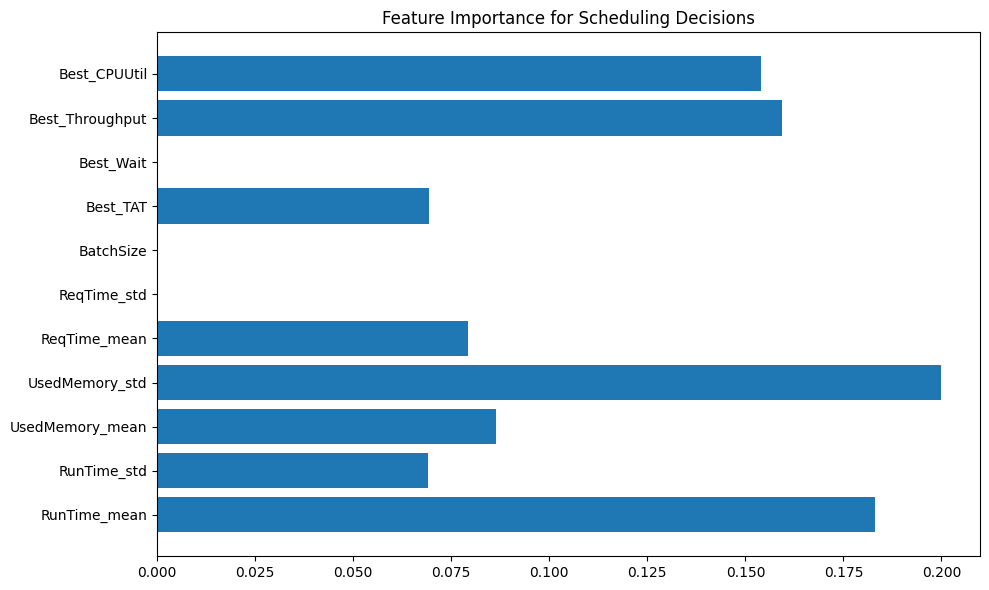

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Load labeled data
data = pd.read_csv("labeled_batches.csv")

# Encode labels
le = LabelEncoder()
X = data.drop('BestAlgo', axis=1)
y = le.fit_transform(data['BestAlgo'])

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Class distribution
class_dist = dict(zip(le.classes_, np.bincount(y)))

# Decision Tree
dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
dt_acc = accuracy_score(y_test, y_pred)
dt_report = classification_report(y_test, y_pred, target_names=le.classes_)

# Feature importance plot
plt.figure(figsize=(10, 6))
importances = dt.feature_importances_
features = X.columns
plt.barh(features, importances)
plt.title("Feature Importance for Scheduling Decisions")
plt.tight_layout()
plt.savefig("feature_importance.png")

# Other models
models = {
    "Decision Tree": DecisionTreeClassifier(max_depth=30),
    "Random Forest": RandomForestClassifier(n_estimators=200),
    "SVM": SVC(kernel='rbf'),
}


data.head(), class_dist, dt_acc, dt_report, accuracies, "feature_importance.png"


<ipython-input-13-91b6b16109fc>:52: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


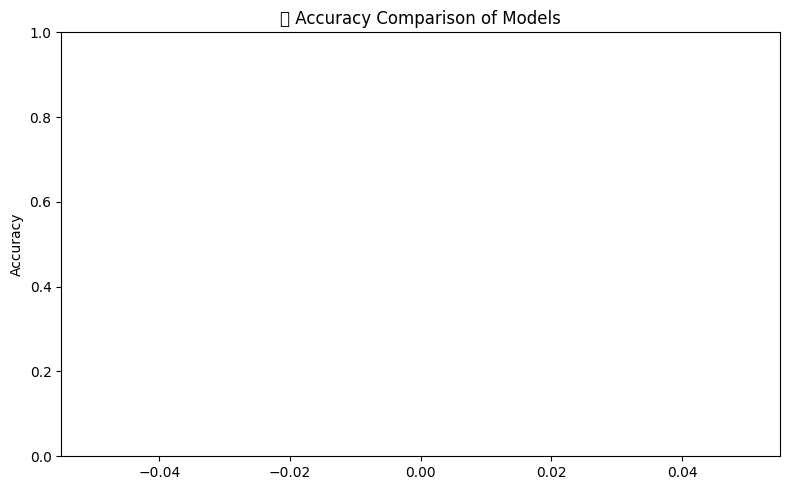